# Gaussian Discriminant Analysis (GDA)

Gaussian Discriminant Analysis (GDA) is a **generative learning algorithm** used for classification. Unlike Logistic Regression (a **discriminative** model that models `P(y | x)` directly), GDA models the **joint distribution** `P(x, y)` and then applies Bayes' Rule to compute `P(y | x)`.


## Assumptions
We assume:
- `y ∼ Bernoulli(ϕ)`
- `x | y = 0 ∼ N(μ0, Σ)`
- `x | y = 1 ∼ N(μ1, Σ)`

Here:
- `ϕ` is the prior probability of class 1
- `μ0`, `μ1` are the class-specific means
- `Σ` is the **shared** covariance matrix


## Objective
Estimate the parameters `ϕ, μ0, μ1, Σ` using MLE (Maximum Likelihood Estimation), then predict the most likely class for a given `x` using Bayes' Rule:

$
P(y=1 \mid x) = \frac{P(x \mid y=1)P(y=1)}{P(x \mid y=0)P(y=0) + P(x \mid y=1)P(y=1)}
$


# 1. Generate a Synthetic Dataset
We’ll create a 2D dataset with two Gaussian blobs to visualize the GDA boundary.

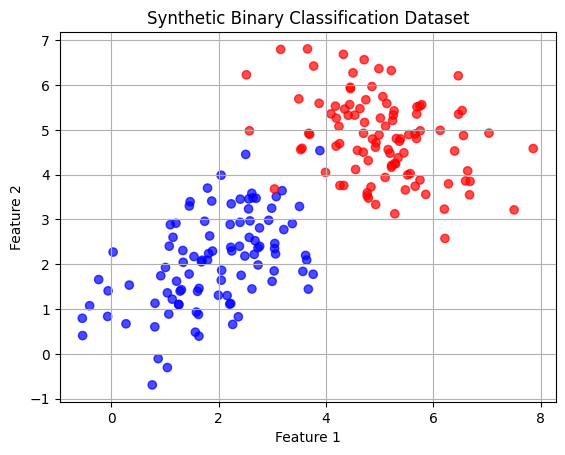

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
X_class0 = np.random.multivariate_normal(mean=[2,2], cov=[[1, 0.5], [0.5, 1]], size = 100)
X_class1 = np.random.multivariate_normal(mean = [5,5], cov=[[1, -0.3], [-0.3, 1]], size = 100)
X = np.vstack([X_class0, X_class1])
y = np.hstack([np.zeros(100), np.ones(100)])

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.title("Synthetic Binary Classification Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

# 2. Implementing GDA Class

We create a GDA class that:
1. **Fits** the model by estimating `ϕ, μ0, μ1, Σ`.
2. Computes **likelihoods** using the multivariate Gaussian formula.
3. **Predicts** the class probability and label for new points.


In [4]:
class GDA:
    def fit(self, X, y):
        self.phi = np.mean(y)
        self.mu0 = np.mean(X[y == 0], axis=0)
        self.mu1 = np.mean(X[y == 1], axis=0)

        # Shared covariance matrix
        m = X.shape[0]
        sigma = np.zeros((X.shape[1], X.shape[1]))
        for i in range(m):
            xi = X[i].reshape(-1, 1)
            mu_yi = self.mu1 if y[i] == 1 else self.mu0
            mu_yi = mu_yi.reshape(-1, 1)
            sigma += (xi - mu_yi) @ (xi - mu_yi).T
        self.sigma = sigma / m

        self.sigma_inv = np.linalg.inv(self.sigma)
        self.det_sigma = np.linalg.det(self.sigma)

    def predict_proba(self, X):
        def gaussian_likelihood(x, mu):
            x_mu = x - mu
            return np.exp(-0.5 * x_mu @ self.sigma_inv @ x_mu.T) / np.sqrt((2 * np.pi) ** X.shape[1] * self.det_sigma)

        probs = []
        for x in X:
            x = x.reshape(1, -1)
            p0 = gaussian_likelihood(x, self.mu0) * (1 - self.phi)
            p1 = gaussian_likelihood(x, self.mu1) * self.phi
            probs.append(p1 / (p0 + p1))
        return np.array(probs)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)


# 3. Train and Evaluate GDA

Now we fit our GDA model and measure its accuracy.

In [5]:
gda = GDA()
gda.fit(X, y)
y_pred = gda.predict(X)

accuracy = np.mean(y_pred == y)
print(f"GDA Accuracy: {accuracy:.2f}")


GDA Accuracy: 0.50


# 4. Visualize Decision Boundary

We plot the GDA decision boundary to understand how it separates the two Gaussian-distributed classes.

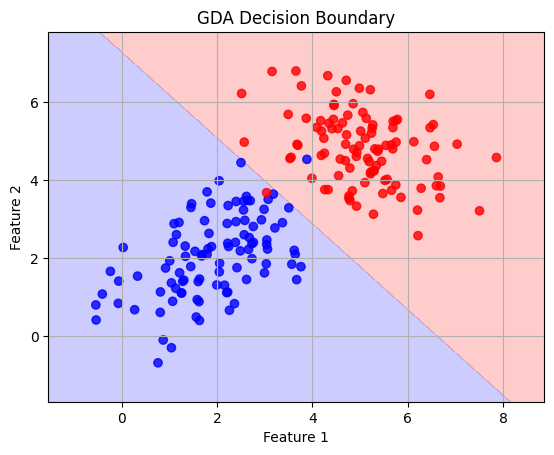

In [6]:
def plot_decision_boundary(predict_fn, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = predict_fn(grid).reshape(xx.shape)

    plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=["blue", "red"])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.8)
    plt.title("GDA Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

plot_decision_boundary(gda.predict_proba, X, y)


# 5. Comparison: GDA vs Logistic Regression

- **GDA** models the **generative process** of the data.
- **Logistic Regression** models `P(y | x)` directly using a sigmoid function.

| Aspect | GDA | Logistic Regression |
|--------|-----|---------------------|
| Type   | Generative | Discriminative |
| Assumes Gaussian class-conditional? | Yes | No |
| Uses Bayes Rule? | Yes | No |
| Handles missing data better? | Often yes | No |

Use GDA when class distributions are well-approximated by Gaussians and you want generative insights.


In [7]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)
y_log_pred = log_reg.predict(X)

log_acc = np.mean(y_log_pred == y)
print(f"Logistic Regression Accuracy: {log_acc:.2f}")


Logistic Regression Accuracy: 0.99


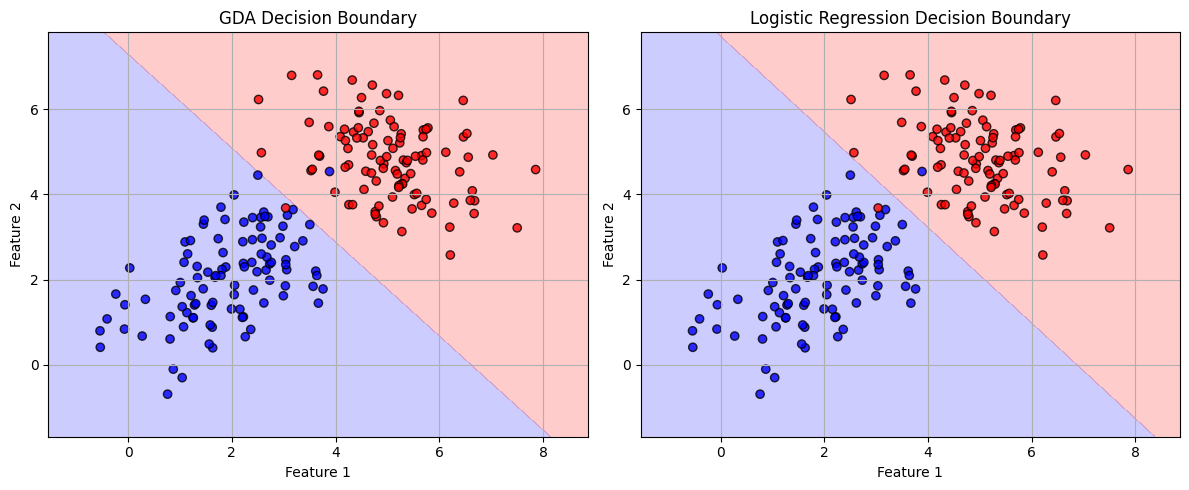

In [8]:
def plot_two_models(gda_model, log_model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Get predictions
    gda_probs = gda_model.predict_proba(grid).reshape(xx.shape)
    log_probs = log_model.predict_proba(grid)[:, 1].reshape(xx.shape)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, probs, title in zip(
        axes, [gda_probs, log_probs], ["GDA Decision Boundary", "Logistic Regression Decision Boundary"]
    ):
        ax.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=["blue", "red"])
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', alpha=0.8)
        ax.set_title(title)
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

plot_two_models(gda, log_reg, X, y)


- Both models may perform similarly when GDA assumptions hold.
- GDA’s decision boundary is **quadratic** if covariance matrices differ; here it's **linear** because we used shared Σ.
- Logistic Regression always yields a **linear boundary**.

In this case, both perform well because the data is **well-separated and Gaussian**. On real-world data with more complexity, their behavior can diverge.
